# Lecture 8: Time Integration

## To be learned:

* Stability
* Hamiltonian systems

### What you should already know:
* [Euler's method](https://en.wikipedia.org/wiki/Euler_method), [Backward Euler's method](https://en.wikipedia.org/wiki/Euler_method#Modifications_and_extensions), [Predictor-corrector method](https://en.wikipedia.org/wiki/Predictor-corrector_method), [Runge-Kutta's method](https://en.wikipedia.org/wiki/Runge-Kutta_methods)

## Part 1: Stability

Suppose we are solving
$$
\begin{align*}
u'(t) &= f(u(t)),\\
u(0) &= u _0
\end{align*}
$$
with the Euler's method:
$$
\frac{u(t+\tau) - u(t)}{\tau} = f(u(t)),
$$
$u\in \mathbb R^n$ --- the vector of $n$ unknowns.

Suppose $u^*$ is the stationary point of the equations: $f(u^*) = 0$. Then, to study stability, we linearize: $f(u) \approx f(u^*) + f'(u^*) (u-u^*)$.
Then denoting $A = f'(u^*)$ and making the change of variables $u\mapsto u+u^*$, we arrive to the system of linear differential equations:
$$
u'(t) = A u(t)
$$
We can furthermore assume, by changing the basis of $\mathbb R^n$ (i.e., the linear change of variables) that $A = {\rm diag}(\lambda _1, \ldots, \lambda _n).$ Then the system of equations reads
$$
u _i'(t) = \lambda _i u _i(t)
$$

The trouble-makers are those $u_i$ for which $\lambda _i$ is negative (more precisely, ${\rm Re}(\lambda _i)$ is negative) and $|\lambda _i|$ is large.
Let us consider such equation, dropping the subscript $i$:
$$
u'(t) = \lambda u(t)
$$
and the corresponding scheme:
$$
\frac{u(t+\tau) - u(t)}{\tau} = \lambda u(t).
$$
We require that the approximate solution $u \to 0$ as $t\to\infty$, which reduces to the condition that $\tau |\lambda| < 2$. This may be too bad if there are large $\lambda$s (note that we have to have the same timestep $\tau$ for the entire system with the whole range of $\lambda$s).

### An idea (Chebyshev methods):
* Consider a two-step explicit scheme:
$$
\begin{align*}
\frac{\tilde{u} - u(t)}{\alpha \tau} &= f(u(t)),\\
\frac{u(t+\tau) - \tilde{u}}{(1-\alpha) \tau} &= f(\tilde{u}),
\end{align*}
$$
(you can think that $\tilde{u}=u(t+\alpha \tau)$).

If you write the corresponding linear system, it will be
$$
u(t+\tau) = (1-\alpha \tau \lambda) (1 - (1-\alpha) \tau \lambda) u(\tau)
$$
and the stability condition is hence
$$
p(\alpha) := (1-\alpha \tau \lambda) (1-(1-\alpha) \tau \lambda) ~~~~ \in [-1,1]
$$
* $p(\alpha)$ is the 2nd-degree polynomial with $p(\alpha)=1$.
* It turns out that the optimal polynomial is such that $\alpha$ are related to the roots of [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials).
* In our case the optimal is $\alpha=(2-\sqrt{2})/4.$
* Stability is then $\tau |\lambda| \leq 8$ (compare to $\tau |\lambda| \leq 2$ earlier)

### Remarks:

* Multistep explicit methods can vastly improve stability (compared to 1- and 2-step methods considered above)

* In general, the stability is characterized by the region of good $\lambda$s on the complex plane (more precisely, the left half-plane).

### References:
* More about stablity [here](https://en.wikipedia.org/wiki/Stiff_equation)
* A good [paper](http://infoscience.epfl.ch/record/148967/files/fourth_order.pdf) to read about Chebyshev method

## Part 2: Hamiltonian systems

Mechanical system: $q = q_1,...,q_N$ are the coordinates of elements of the system (e.g., particles). The system has the potential energy $E(q_1, ..., q_N)$.

So, Newton's equations:
$$
m_i \ddot{q} _i = -\frac{\partial}{\partial q_i} E(q)
$$

Equivalently: Define the Hamiltonian (=total energy of the system) $H(q,p) := E(q) + \sum_i \frac{p_i^2}{2 m}$, where $p_i$ is the momentum of the $i$-th particle. And hence write down the Hamiltonian equations:
$$
\begin{align*}
\dot{p} _i &= -\frac{\partial H}{\partial q_i} \\
\dot{q} _i &= \frac{\partial H}{\partial p_i}
\end{align*}
$$

**Exercise** Prove that
$$
\dot{H} := \frac{d}{dt} H(q(t), p(t))
$$
is identically zero.

### Explicit scheme: no energy conservation:

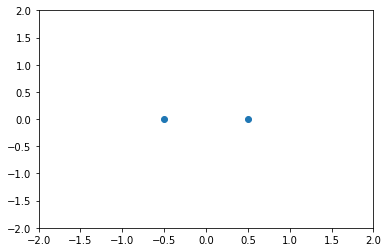

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

q = np.array([[-0.5, 0.0], [0.5, 0.0]])
p = np.array([[0.0, -0.5], [0.0, 0.5]])
hist = [q];
dt = 0.1
N_iter_between_frames = 2
N_frames = 200
for i in range(0, N_frames*N_iter_between_frames+1):
    force = (q[0,:]-q[1,:])/np.dot(q[0,:]-q[1,:],q[0,:]-q[1,:])
    q = q + dt*p 
    p[0,:] = p[0,:] - dt*force
    p[1,:] = p[1,:] + dt*force
    if(np.mod(i,N_iter_between_frames)==0):
        hist.append(q)
        
fig, ax = plt.subplots()

line, = ax.plot(np.transpose(q[:,0]),np.transpose(q[:,1]),'o')

def animate(i):
    line.set_xdata(np.transpose(hist[i][:,0]))
    line.set_ydata(np.transpose(hist[i][:,1]))
    return line,

def init():
    line.set_xdata(np.transpose(hist[0][:,0]))
    line.set_ydata(np.transpose(hist[0][:,1]))
    return line,

ani = animation.FuncAnimation(fig, animate, N_frames, init_func=init,
    interval=25)

plt.axis([-2,2,-2,2])
#plt.show()

from IPython.display import HTML
HTML(ani.to_jshtml())

### Simplectic (velocity Verlet): energy conservation

For simplicity assume all $m_i = 1$:
$$
\begin{align*}
q(t+\tau/2) &= q(t) + {\textstyle \frac{\tau}{2}} p(t), \\
p(t+\tau) &= p(t) - \tau \nabla E(q(t+\tau/2)), \\
q(t+\tau) &= q(t+\tau/2) + {\textstyle \frac{\tau}{2}} p(t+\tau), \\
\end{align*}
$$

* (Can also be interepreted as a time-splitting method)
* Explicit!
* Time reversible!! (I.e., operation $t \mapsto -t$, $p \mapsto -p$ leaves the discrete scheme invariant)

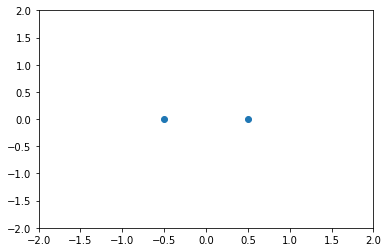

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

q = np.array([[-0.5, 0.0], [0.5, 0.0]])
p = np.array([[0.0, -0.5], [0.0, 0.5]])
hist = [q];
dt = 0.1
N_iter_between_frames = 200
N_frames = 200
for i in range(0, N_frames*N_iter_between_frames+1):
    q = q + 0.5*dt*p 
    force = (q[0,:]-q[1,:])/np.dot(q[0,:]-q[1,:],q[0,:]-q[1,:])
    p[0,:] = p[0,:] - dt*force
    p[1,:] = p[1,:] + dt*force
    q = q + 0.5*dt*p
    if(np.mod(i,N_iter_between_frames)==0):
        hist.append(q)
        
fig, ax = plt.subplots()

line, = ax.plot(np.transpose(q[:,0]),np.transpose(q[:,1]),'o')

def animate(i):
    line.set_xdata(np.transpose(hist[i][:,0]))
    line.set_ydata(np.transpose(hist[i][:,1]))
    return line,

def init():
    line.set_xdata(np.transpose(hist[0][:,0]))
    line.set_ydata(np.transpose(hist[0][:,1]))
    return line,

ani = animation.FuncAnimation(fig, animate, N_frames, init_func=init,
    interval=25)
plt.axis([-2,2,-2,2])
#plt.show()

from IPython.display import HTML
HTML(ani.to_jshtml())

### Approximate Energy conservation

[Mathematica computations](Simplectic.nb)